In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import folium
from folium import Choropleth, Circle, Marker, PolyLine
import squarify
import ast
import pickle
import warnings
import math

import geopy
from geopy.distance import geodesic

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from mpl_toolkits.mplot3d import Axes3D 
from datetime import datetime
from haversine import haversine

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, QuantileTransformer, RobustScaler

In [33]:
def cal_rad(A,B):
    rad = math.atan2(A[1]-B[1], A[0]-B[0])
    return rad

def count_color(count):
    if count >=4:
        color = '#c18cd1'
    elif count ==3:
        color = '#bc65d6'
    elif count ==2:
        color = '#b940de'
    elif count ==1:
        color = '#b223de'
    else:
        color = '#9000c9'
    return color

In [34]:
def geo_cluster_color(id):
    if id == 0:
        color = '#ef476f' # 빨강
        opacity = 1
    elif id == 1:
        color = '#06d6a0' # 초록
        opacity = 0.1
    elif id == 2:
        color = '#ffd166' # 노랑
        opacity = 0.1
    elif id == 3:
        color = '#118ab2' # 파랑
        opacity = 0.1
    else:
        color = '#000000'
        opacity = 0.1
    return color, opacity

In [35]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [36]:
def cal_dist(x1, y1, x2, y2, a, b):
    area = abs((x1-a) * (y2-b) - (y1-b) * (x2 - a))
    AB = ((x1-x2)**2 + (y1-y2)**2) **0.5
    distance = area/AB
    return distance

In [37]:
#고속도로 구간별 좌표 load
traffic_df = pd.read_csv('도로종류별 교통량(좌표,휴게소,사고건수,화물차휴게소)추가_최종본.csv')
traffic_df.shape

(638, 19)

In [38]:
#ast library 사용
traffic_df['startpoint_coor'] = traffic_df['startpoint_coor'].apply(ast.literal_eval)
traffic_df['endpoint_coor'] = traffic_df['endpoint_coor'].apply(ast.literal_eval)

In [39]:
#변수로 사용할 각 노선별 거리 측정
km_list = []
for i in range(len(traffic_df)):
    startpoint = traffic_df['startpoint_coor'][i]
    endpoint = traffic_df['endpoint_coor'][i]
    
    km = haversine(startpoint,endpoint)
    km_list.append(km)
traffic_df['distance'] = km_list

In [40]:
#지역 군집화
x = []
y = []
for i in range(len(traffic_df)):
    start_x, start_y = traffic_df['startpoint_coor'][i]
    end_x, end_y = traffic_df['endpoint_coor'][i]
    
    center_x = (start_x + end_x) / 2
    center_y = (start_y + end_y) / 2
    
    x.append(center_x)
    y.append(center_y)

traffic_df['center_x'] = x
traffic_df['center_y'] = y

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, QuantileTransformer, RobustScaler

data = traffic_df[['center_x', 'center_y']].values
data = StandardScaler().fit_transform(data)
kmeans = KMeans(n_clusters=4, random_state=51).fit(data) # 51
traffic_df['geo_cluster_id'] = kmeans.labels_

In [42]:
traffic_df.drop('Unnamed: 0',axis=1,inplace=True)

In [43]:
#강원지역만 필터링
traffic_df_gangwon = traffic_df[traffic_df['geo_cluster_id'] == 1]

In [44]:
traffic_df_gangwon.reset_index(inplace=True)
traffic_df_gangwon.head()

,index,노선번호,구간,이정,연장,2017,2018,2019,2020,계,...,startpoint,endpoint,startpoint_coor,endpoint_coor,rest_count,accident_count,distance,center_x,center_y,geo_cluster_id
0,271,NaN,회인IC~보은IC,18.8~29.6,10.8,40711.0,35166.0,37124.0,37771.0,"44,142",...,회인IC,보은IC,"(36.4867607216413, 127.608658835495)","(36.45669341997925, 127.72057897489313)",0,1,10.551324,36.471727,127.664619,1
1,272,NaN,보은IC~속리산IC,29.6~35.6,6.0,37958.0,42308.0,39213.0,37586.0,"41,240",...,보은IC,속리산IC,"(36.45669341997925, 127.72057897489313)","(36.4556382830322, 127.786916855392)",0,0,5.934122,36.456166,127.753748,1
2,273,NaN,속리산IC~화서IC,35.6~51.8,16.2,35982.0,40774.0,36231.0,34601.0,"39,554",...,속리산IC,화서IC,"(36.4556382830322, 127.786916855392)","(36.4425366912992, 127.962402816848)",2,6,15.763568,36.449087,127.874660,1
3,274,NaN,화서IC~남상주IC,51.8~70.8,19.0,36847.0,40171.0,37625.0,35744.0,"39,939",...,화서IC,남상주IC,"(36.4425366912992, 127.962402816848)","(36.3678425216301, 128.140642144337)",0,6,17.984167,36.405190,128.051522,1
4,337,NaN,음성IC~서충주IC,72.4~77.8,5.4,28589.0,31748.0,30720.0,30506.0,"33,759",...,음성IC,서충주IC,"(36.9888709152251, 127.619380194658)","(37.0099220870185, 127.671334266729)",0,0,5.173614,36.999397,127.645357,1


In [45]:
#지도 시각화
counts=[]
grouping_map = folium.Map(location=[36, 127.5], tiles='cartodbpositron', zoom_start=7)

for i in range(len(traffic_df_gangwon)):
    startpoint = traffic_df_gangwon['startpoint_coor'][i]
    endpoint = traffic_df_gangwon['endpoint_coor'][i]

    rad = cal_rad(startpoint, endpoint)
    deg = np.rad2deg(rad)
    dist = 1.5
    origin_start = geopy.Point(startpoint)
    origin_end = geopy.Point(endpoint)

    degree = [90+deg, 270+deg]

    poly_a = []
    poly_b = []


    for de in degree:
        destination_start = geodesic(kilometers=dist).destination(origin_start, de)
        destination_end = geodesic(kilometers=dist).destination(origin_end, de)
        new_lat1, new_lon1 = destination_start.latitude, destination_start.longitude
        new_lat2, new_lon2 = destination_end.latitude, destination_end.longitude

        poly_a.append([new_lat1, new_lon1])
        poly_b.append([new_lat2, new_lon2])

        
    polygon_vect = np.array([poly_a[0],poly_b[0],poly_b[1],poly_a[1]])
    polygon = Polygon(polygon_vect)
    
    folium.Polygon(locations=[poly_a[0], poly_b[0], poly_b[1], poly_a[1]],
                  weight = 1,
                  color = None, # traffic_color(traffic_df['traffic'][i])[0], #'#4287f5',
                  fill_color = geo_cluster_color(id = traffic_df_gangwon['geo_cluster_id'][i])[0], # '#50aa50', 
                  fill_opacity=0.8, #0.2
                      ).add_to(grouping_map)

In [46]:
grouping_map

In [47]:
grouping_map.save('강원도 지역 고속도로 시각화.html')

In [48]:
#휴게소 없는 구간 filtering
traffic_df_gangwon = traffic_df_gangwon[traffic_df_gangwon['rest_count'] != 0]
traffic_df_gangwon['rest_count'].value_counts()

2    13
1     6
Name: rest_count, dtype: int64

In [49]:
#사고가 일어나지 않은 구간 filtering
traffic_df_gangwon = traffic_df_gangwon[traffic_df_gangwon['accident_count'] != 0]
traffic_df_gangwon.shape

(8, 23)

In [50]:
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = r'C:\Users\Jo\PYDATAexam\font\malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [65]:
#elbow method 
def elbow_method(df):
    cols = ['accident_count','3~12종','distance']
    scaler = ['minmax', 'standard', 'robust']
    box = {}

    fig, axes = plt.subplots(1,3,figsize = (18 , 5))

    for i, scale in enumerate(scaler):
        data = df[cols].values
        if scale == 'minmax':
            data = MinMaxScaler().fit_transform(data)
        elif scale == 'standard':
            data = StandardScaler().fit_transform(data)
        elif scale == 'robust':
            data = RobustScaler().fit_transform(data)

        distortions = []
        for j in range(1,7):
            data = df[cols].values
            kmeans = KMeans(n_clusters=j).fit(data)
            distortions.append(kmeans.inertia_)

        axes[i].plot(range(1, 7), distortions, marker='o')
        axes[i].set_title(scale)
        axes[i].set_xlabel('Number of clusters')
        axes[i].set_ylabel('Distortion')
        
    plt.show()

In [66]:
#군집평가 : 실루엣 분석
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

feature_names = ['accident_count','3~12종','distance']
silhouette_df = traffic_df_gangwon[feature_names]
kmeans = KMeans(n_clusters=3).fit(silhouette_df)
silhouette_df['cluster'] = kmeans.labels_

score_samples = silhouette_samples(silhouette_df.to_numpy(),silhouette_df['cluster'])
print('silhouette_samples() return 값의 shape',score_samples.shape)

silhouette_df['silhouette_coeff'] = score_samples

average_score = silhouette_score(silhouette_df.to_numpy(),silhouette_df['cluster'])
print('silhouette analysis score:{0:.3f}'.format(average_score))
silhouette_df.head()

silhouette_samples() return 값의 shape (8,)
silhouette analysis score:0.762


C:\Users\Jo\AppData\Local\Temp\ipykernel_27932\3212360106.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  silhouette_df['cluster'] = kmeans.labels_
C:\Users\Jo\AppData\Local\Temp\ipykernel_27932\3212360106.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  silhouette_df['silhouette_coeff'] = score_samples


,accident_count,3~12종,distance,cluster,silhouette_coeff
2,6,3800,15.763568,0,0.950492
7,3,2492,10.813693,2,0.561847
11,13,5496,13.368577,1,0.978394
13,22,5460,13.506793,1,0.977932
29,1,3182,8.080314,2,0.402389


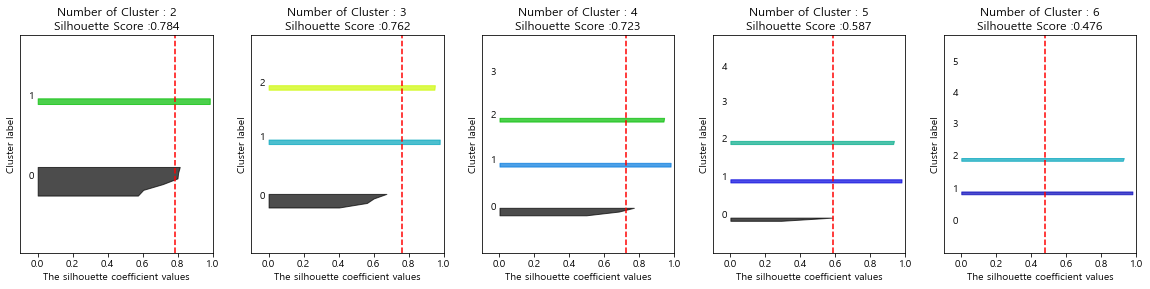

In [67]:
visualize_silhouette([2,3,4,5,6], silhouette_df.to_numpy())

C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


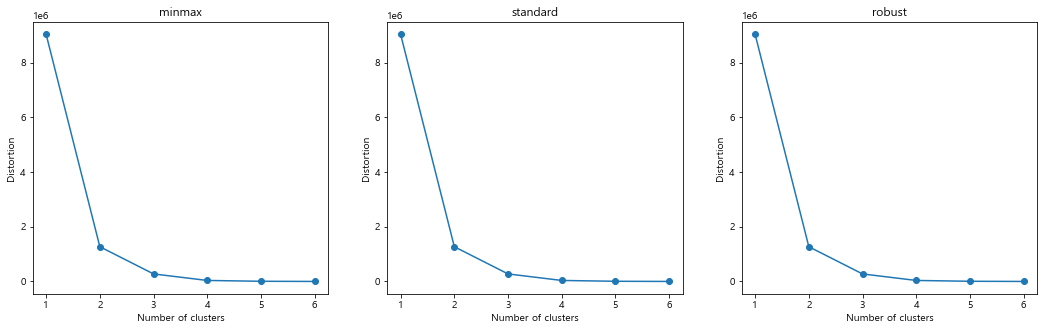

In [68]:
elbow_method(traffic_df_gangwon)

In [69]:
silhouette_df_copy = silhouette_df[['accident_count','3~12종','cluster','distance']]

In [70]:
#차원 축소
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(silhouette_df_copy[['distance','accident_count','3~12종']].to_numpy())

silhouette_df_copy['pca_x'] = pca_transformed[:,0]
silhouette_df_copy['pca_y'] = pca_transformed[:,1]
silhouette_df_copy.head()

,accident_count,3~12종,cluster,distance,pca_x,pca_y
2,6,3800,0,15.763568,28.488563,-3.178022
7,3,2492,2,10.813693,-1279.509396,2.492019
11,13,5496,1,13.368577,1724.501225,-4.001054
13,22,5460,1,13.506793,1688.550320,4.279245
29,1,3182,2,8.080314,-589.530688,-1.500846


In [ ]:
plt.scatter(x=silhouette_df_copy['pca_x'],y=silhouette_df_copy['pca_y'],edgecolor='k',c=silhouette_df_copy['cluster'])

In [ ]:
#군집화
def cluster(df, seed):
    cols = ['accident_count','3~12종','distance']
    data = df[cols].values
    data = StandardScaler().fit_transform(data)

    kmeans = KMeans(n_clusters=3, random_state=seed).fit(data)
    df['cluster_id'] = kmeans.labels_
    return df

In [ ]:
group_df = cluster(traffic_df_gangwon, 0)

In [ ]:
group_df.reset_index(inplace=True)
group_df.head()

In [ ]:
def cluster_color(id):
    if id == 0:
        color = '#ef476f'
        opacity = 1
    elif id == 1:
        color = '#06d6a0'
        opacity = 0.1
    else:
        color = '#118ab2'
        opacity = 0.1        
    return color, opacity

In [ ]:
counts=[]
cluster_map = folium.Map(location=[36, 127.5], tiles='cartodbpositron', zoom_start=7)
res = []
for i in range(len(group_df)):
    startpoint = group_df['startpoint_coor'][i]
    endpoint = group_df['endpoint_coor'][i]

    rad = cal_rad(startpoint, endpoint)
    deg = np.rad2deg(rad)
    dist = 1.5
    origin_start = geopy.Point(startpoint)
    origin_end = geopy.Point(endpoint)

    degree = [90+deg, 270+deg]

    poly_a = []
    poly_b = []

    for de in degree:

        destination_start = geodesic(kilometers=dist).destination(origin_start, de)
        destination_end = geodesic(kilometers=dist).destination(origin_end, de)
        new_lat1, new_lon1 = destination_start.latitude, destination_start.longitude
        new_lat2, new_lon2 = destination_end.latitude, destination_end.longitude

        poly_a.append([new_lat1, new_lon1])
        poly_b.append([new_lat2, new_lon2])
      
    polygon_vect = np.array([poly_a[0],poly_b[0],poly_b[1],poly_a[1]])
    polygon = Polygon(polygon_vect)

    folium.Polygon(locations=[poly_a[0], poly_b[0], poly_b[1], poly_a[1]],
                  weight = 1,
                  color = None, # traffic_color(traffic_df['traffic'][i])[0], #'#4287f5',
                  fill_color = cluster_color(id = group_df['cluster_id'][i])[0], # '#50aa50', 
                  fill_opacity=cluster_color(id = group_df['cluster_id'][i])[1],
                  tooltip=group_df['구간'][i]
                      ).add_to(cluster_map)
    
    if cluster_color(id = group_df['cluster_id'][i])[0] == '#ef476f':
        res.append(group_df.iloc[i]['구간'])

In [ ]:
import pandas as pd

rest_df = pd.read_csv('고속도로 휴게소 데이터.csv')
rest_df.head()

In [ ]:
truck_no = rest_df[rest_df['truckSaYn'] == 'O']
truck_no.head()

In [ ]:
for name, lat, lng in zip(rest_df.serviceAreaName, rest_df.위도, rest_df.경도):
    folium.CircleMarker([lat, lng],
                        radius=6,         # 원의 반지름
                        color='brown',         # 원의 둘레 색상
                        weight=0.1,
                        fill=True,
                        fill_color='blue',    # 원을 채우는 색
                        fill_opacity=0.5, # 투명도    
                        popup=name
    ).add_to(cluster_map)

In [ ]:
cluster_map